In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import DataLoader

In [2]:
# Dataset 
raw_data = load_boston()

data = raw_data.data
# label = raw_data.data

np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10

X_train = data[:trainset_size,:]
X_test = data[trainset_size:,:]

print(X_train.shape)
print(X_test.shape)

(354, 13)
(152, 13)


In [3]:
# Preprocessing 
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)
print(X_train.mean(0))
print(X_test.mean(0))

tensor([-2.2965e-16, -6.4606e-17,  4.0156e-15, -2.0825e-16, -1.2093e-15,
         5.0261e-15,  3.2868e-16,  9.5529e-16, -8.2169e-17,  7.4975e-17,
         2.1178e-14,  8.8366e-15, -4.8956e-16], dtype=torch.float64)
tensor([-0.0916, -0.1311,  0.0256, -0.0546,  0.0460, -0.0035,  0.0290,  0.0152,
         0.0167,  0.0428,  0.0894, -0.0318,  0.0267], dtype=torch.float64)


In [4]:
# Models 
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z

        
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 5
LATENT_DIM = 5
BATCH_SIZE = 64
N_EPOCHS = 1000
lr = 1e-3
# weight_decay = 1e-2

In [6]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [7]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)

In [8]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [9]:
# optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)

In [10]:
train_loss_avg = []
test_losses = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    for x in train_iter: 
#         x = x.type(torch.float64)
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        
        mu_x, std_x = dec(z_samples)
        
        # Loss
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward 
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    
    # Test loss 
    # Forward pass 
#     mu_z_test, std_z_test = enc(X_test)
#     eps_test = torch.randn_like(std_z_test)
#     z_samples_test = mu_z_test + torch.exp(std_z_test) * eps_test

#     mu_x_test, std_x_test = dec(z_samples_test)

#     # Loss
#     test_loss = loss_fn(mu_z_test, std_z_test, z_samples_test, mu_x_test, std_x_test, X_test)
    
#     test_losses.append(test_loss.item())
    
    mu_z, std_z = enc(X_test)
    
    eps = torch.randn_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)

    mu_x, std_x = dec(z_samples)

    loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, X_test)

    test_losses.append(loss.item())
    
    print("Epoch [%d / %d] average loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1]))
#     print("Epoch [%d / %d] test loss: %f" % (i+1, N_EPOCHS, test_losses[-1]))

Epoch [1 / 1000] average loss: 24.268460
Epoch [2 / 1000] average loss: 23.361210
Epoch [3 / 1000] average loss: 22.973139
Epoch [4 / 1000] average loss: 22.378375
Epoch [5 / 1000] average loss: 21.689927
Epoch [6 / 1000] average loss: 21.753206
Epoch [7 / 1000] average loss: 21.712064
Epoch [8 / 1000] average loss: 21.534473
Epoch [9 / 1000] average loss: 21.390045
Epoch [10 / 1000] average loss: 21.052552
Epoch [11 / 1000] average loss: 20.810034
Epoch [12 / 1000] average loss: 20.813786
Epoch [13 / 1000] average loss: 20.505401
Epoch [14 / 1000] average loss: 20.405369
Epoch [15 / 1000] average loss: 20.299398
Epoch [16 / 1000] average loss: 20.323080
Epoch [17 / 1000] average loss: 20.292650
Epoch [18 / 1000] average loss: 20.226786
Epoch [19 / 1000] average loss: 20.133621
Epoch [20 / 1000] average loss: 19.908178
Epoch [21 / 1000] average loss: 19.842469
Epoch [22 / 1000] average loss: 19.859535
Epoch [23 / 1000] average loss: 19.779910
Epoch [24 / 1000] average loss: 19.767263
E

Epoch [197 / 1000] average loss: 10.328079
Epoch [198 / 1000] average loss: 9.933699
Epoch [199 / 1000] average loss: 9.868624
Epoch [200 / 1000] average loss: 10.134754
Epoch [201 / 1000] average loss: 10.184180
Epoch [202 / 1000] average loss: 10.776159
Epoch [203 / 1000] average loss: 10.866711
Epoch [204 / 1000] average loss: 10.390245
Epoch [205 / 1000] average loss: 10.745671
Epoch [206 / 1000] average loss: 10.844702
Epoch [207 / 1000] average loss: 10.221163
Epoch [208 / 1000] average loss: 10.235740
Epoch [209 / 1000] average loss: 10.111529
Epoch [210 / 1000] average loss: 9.976808
Epoch [211 / 1000] average loss: 10.151983
Epoch [212 / 1000] average loss: 9.862745
Epoch [213 / 1000] average loss: 10.175294
Epoch [214 / 1000] average loss: 9.775099
Epoch [215 / 1000] average loss: 9.493855
Epoch [216 / 1000] average loss: 9.762016
Epoch [217 / 1000] average loss: 9.711863
Epoch [218 / 1000] average loss: 9.718995
Epoch [219 / 1000] average loss: 9.514435
Epoch [220 / 1000] av

Epoch [398 / 1000] average loss: 6.496835
Epoch [399 / 1000] average loss: 6.709932
Epoch [400 / 1000] average loss: 6.609026
Epoch [401 / 1000] average loss: 6.551951
Epoch [402 / 1000] average loss: 6.568429
Epoch [403 / 1000] average loss: 6.384460
Epoch [404 / 1000] average loss: 6.200764
Epoch [405 / 1000] average loss: 6.598620
Epoch [406 / 1000] average loss: 6.175031
Epoch [407 / 1000] average loss: 6.161540
Epoch [408 / 1000] average loss: 6.395502
Epoch [409 / 1000] average loss: 6.299411
Epoch [410 / 1000] average loss: 6.136614
Epoch [411 / 1000] average loss: 5.973569
Epoch [412 / 1000] average loss: 5.995341
Epoch [413 / 1000] average loss: 6.210107
Epoch [414 / 1000] average loss: 6.006334
Epoch [415 / 1000] average loss: 6.225978
Epoch [416 / 1000] average loss: 7.277407
Epoch [417 / 1000] average loss: 6.580782
Epoch [418 / 1000] average loss: 6.773950
Epoch [419 / 1000] average loss: 6.959063
Epoch [420 / 1000] average loss: 6.515931
Epoch [421 / 1000] average loss: 6

Epoch [604 / 1000] average loss: 4.598354
Epoch [605 / 1000] average loss: 4.584594
Epoch [606 / 1000] average loss: 4.845800
Epoch [607 / 1000] average loss: 4.744744
Epoch [608 / 1000] average loss: 4.547136
Epoch [609 / 1000] average loss: 4.339972
Epoch [610 / 1000] average loss: 4.380098
Epoch [611 / 1000] average loss: 4.482062
Epoch [612 / 1000] average loss: 4.533315
Epoch [613 / 1000] average loss: 4.842499
Epoch [614 / 1000] average loss: 4.668530
Epoch [615 / 1000] average loss: 4.768313
Epoch [616 / 1000] average loss: 4.500087
Epoch [617 / 1000] average loss: 4.525157
Epoch [618 / 1000] average loss: 6.036275
Epoch [619 / 1000] average loss: 11.350371
Epoch [620 / 1000] average loss: 6.288253
Epoch [621 / 1000] average loss: 6.477247
Epoch [622 / 1000] average loss: 6.791526
Epoch [623 / 1000] average loss: 6.430610
Epoch [624 / 1000] average loss: 6.028332
Epoch [625 / 1000] average loss: 5.840117
Epoch [626 / 1000] average loss: 5.233902
Epoch [627 / 1000] average loss: 

Epoch [809 / 1000] average loss: 3.104727
Epoch [810 / 1000] average loss: 2.959921
Epoch [811 / 1000] average loss: 3.077928
Epoch [812 / 1000] average loss: 3.166673
Epoch [813 / 1000] average loss: 2.845555
Epoch [814 / 1000] average loss: 3.220698
Epoch [815 / 1000] average loss: 3.667879
Epoch [816 / 1000] average loss: 3.254088
Epoch [817 / 1000] average loss: 3.534838
Epoch [818 / 1000] average loss: 3.089639
Epoch [819 / 1000] average loss: 3.025723
Epoch [820 / 1000] average loss: 3.304565
Epoch [821 / 1000] average loss: 3.333463
Epoch [822 / 1000] average loss: 3.971745
Epoch [823 / 1000] average loss: 4.346052
Epoch [824 / 1000] average loss: 4.738803
Epoch [825 / 1000] average loss: 3.758879
Epoch [826 / 1000] average loss: 3.824586
Epoch [827 / 1000] average loss: 3.471674
Epoch [828 / 1000] average loss: 3.658237
Epoch [829 / 1000] average loss: 3.098468
Epoch [830 / 1000] average loss: 2.952616
Epoch [831 / 1000] average loss: 2.982309
Epoch [832 / 1000] average loss: 2

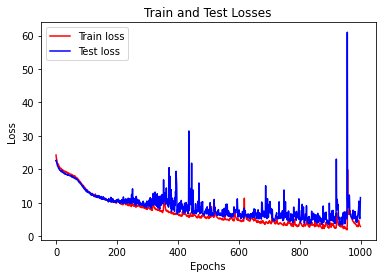

In [11]:
plt.plot(train_loss_avg, "r")
plt.plot(test_losses, "b")
plt.legend(["Train loss", "Test loss"])
plt.title("Train and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [12]:
max(test_losses)

61.01631850905789

In [13]:
test_losses

[22.557511009511167,
 22.77145078846765,
 22.08733219280393,
 21.684014074191506,
 21.355675940519184,
 20.957114526235788,
 20.875611451934642,
 20.677699214743388,
 20.363982880400446,
 20.247680962120732,
 20.291738933847228,
 19.964524250293287,
 19.83369014984003,
 19.87388821390342,
 19.645215614587148,
 19.57971939700322,
 19.5683609987366,
 19.30144378254777,
 19.299055101376606,
 19.67474451448647,
 19.444564953281905,
 19.1118355735249,
 19.08328490608645,
 19.022601085970486,
 19.004193151538164,
 19.069839871670016,
 18.87716533553525,
 18.711111846089835,
 18.7827949834004,
 18.759004071443876,
 18.537522911660545,
 18.604855966094473,
 18.64902666426239,
 18.535101204739757,
 18.5242895910531,
 18.372031820022674,
 18.360550064410674,
 18.461451706351482,
 18.396473945008097,
 18.206385350040996,
 18.386110089584307,
 18.306697153194378,
 18.233720483648927,
 18.16752289740344,
 18.127370571619167,
 18.161696251985642,
 18.06668942423022,
 18.07384746133253,
 18.072093368

## Evaluation

In [14]:
# Sample x_samples
S = X_test.shape[0]
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
# mu_x, std_x = decoder(z, Y_test)   
mu_x, std_x = dec(z)

In [15]:
eps = torch.distributions.Normal(0, 1).sample(std_x.shape)
x_samples = mu_x + std_x * eps

Text(0, 0.5, 'Mean of Generated Distribution')

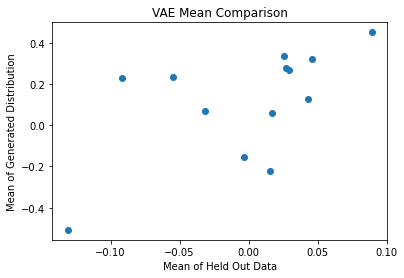

In [16]:
plt.scatter(X_test.mean(0).detach().numpy(), x_samples.mean(0).detach().numpy())
plt.title("VAE Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

Text(0, 0.5, 'Standard Deviation of Generated Distribution')

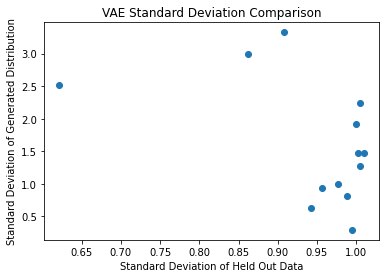

In [17]:
plt.scatter(X_test.std(0).detach().numpy(), x_samples.std(0).detach().numpy())
plt.title("VAE Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

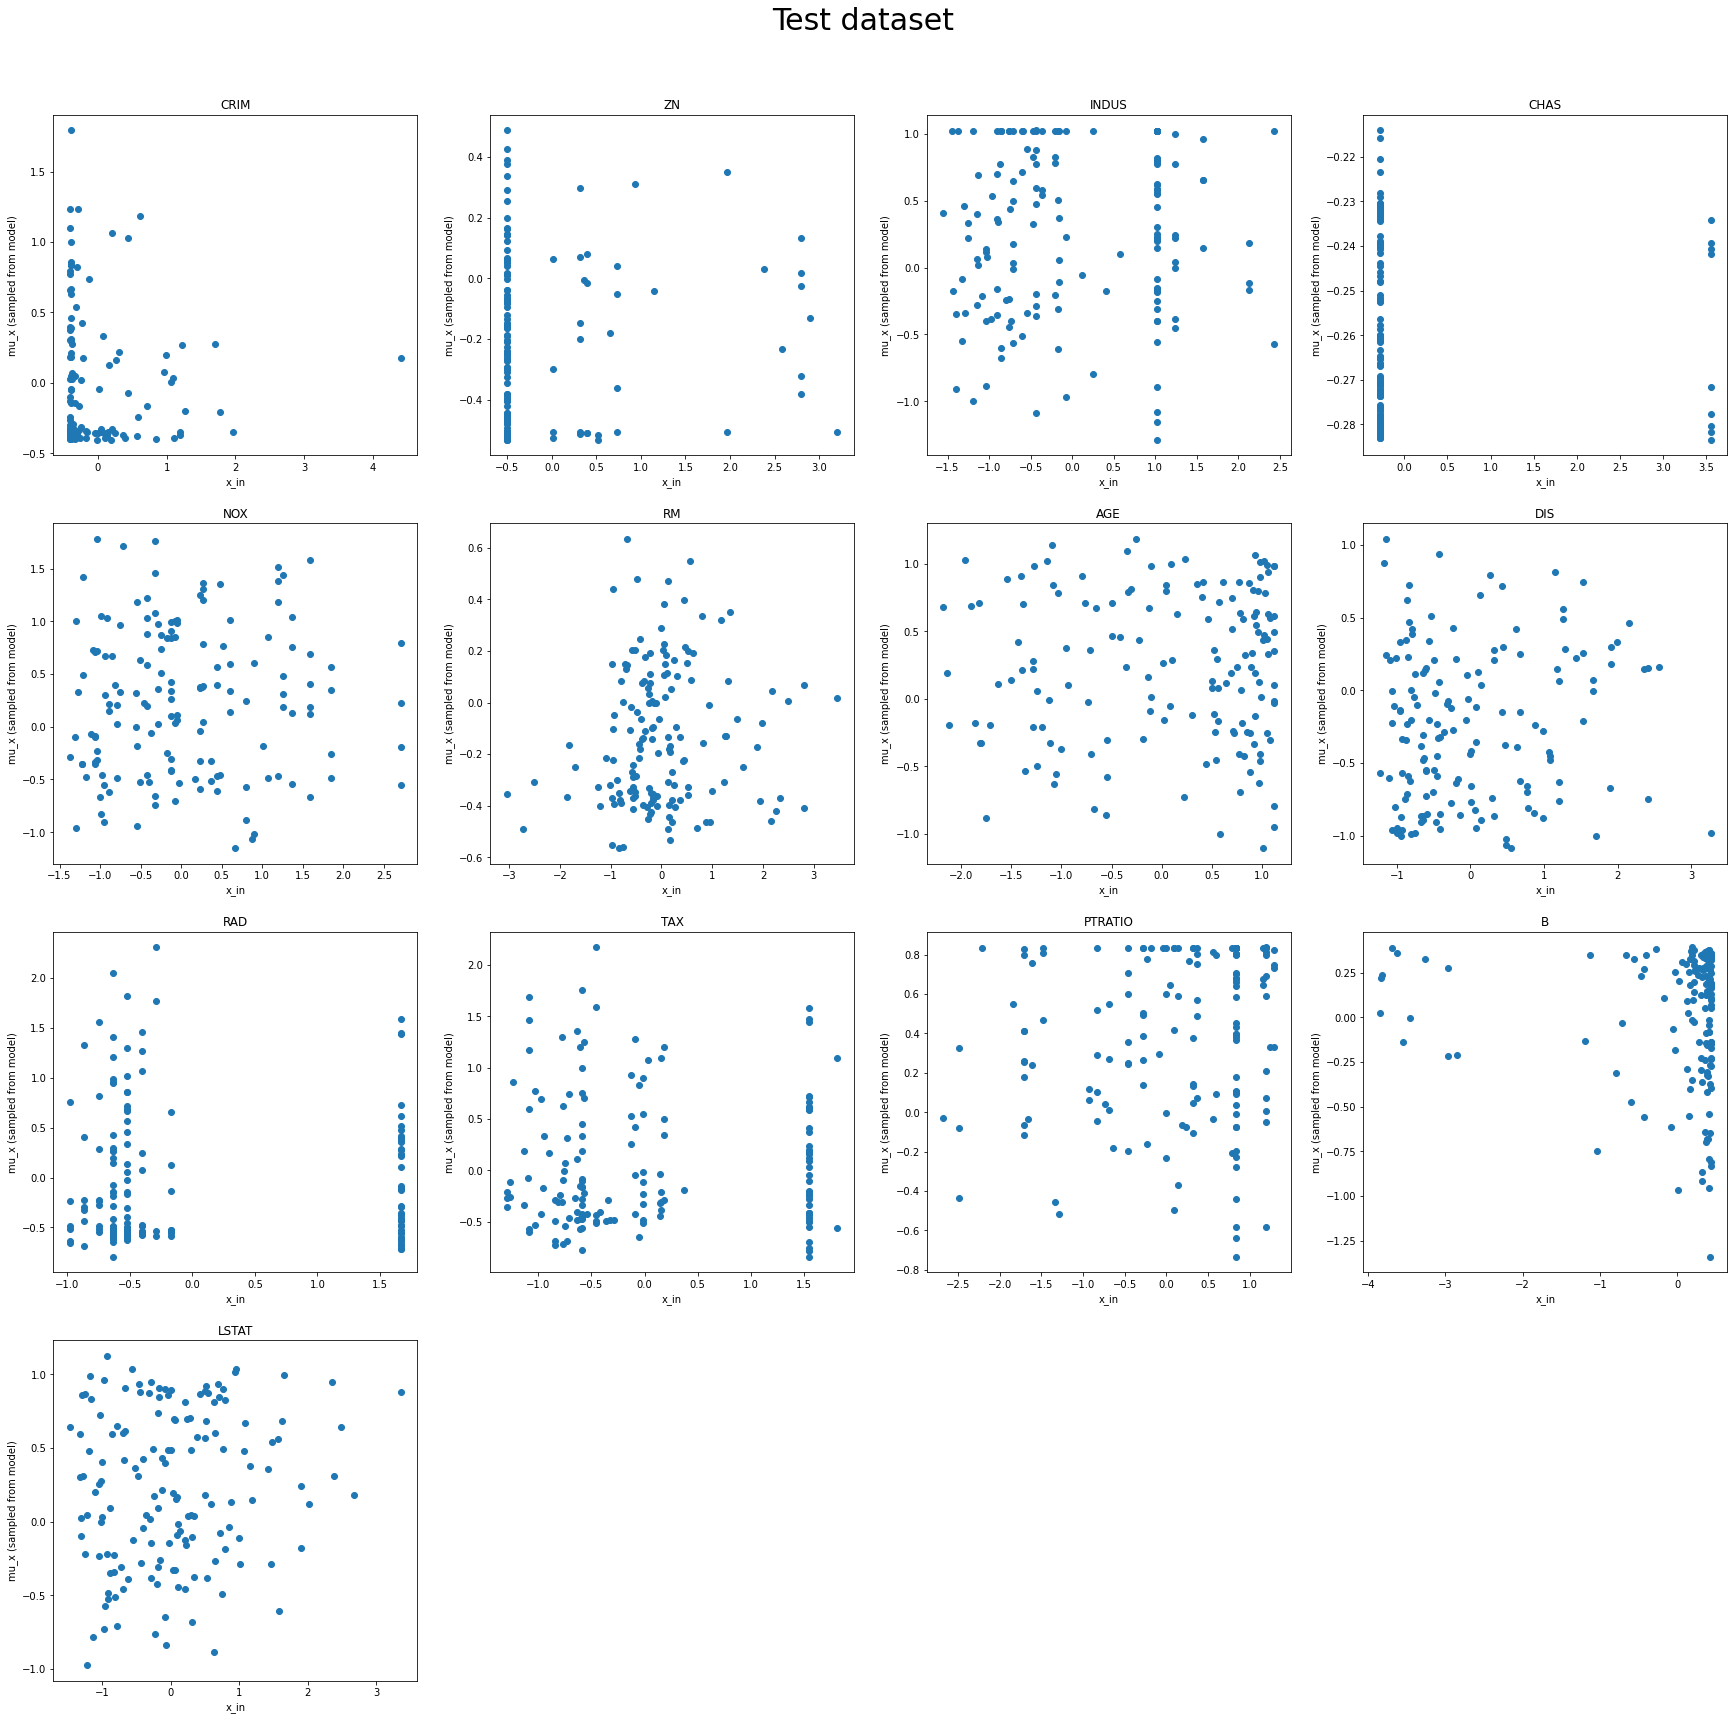

In [18]:
x_test = X_test.detach().numpy()
mu_x = mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 

for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(x_test[:,i*4+j], mu_x[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (sampled from model)")
        axs[i, j].set_xlabel("x_in")
    if i*4+j >= 13: 
        break 

plt.suptitle("Test dataset", fontsize=30, y=0.9)
plt.subplots_adjust(top=0.85)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3])
        
plt.show()

In [19]:
# Sample x_samples
S = X_train.shape[0]
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

torch.Size([354, 13])


## mu_x vs. x_in on train dataset

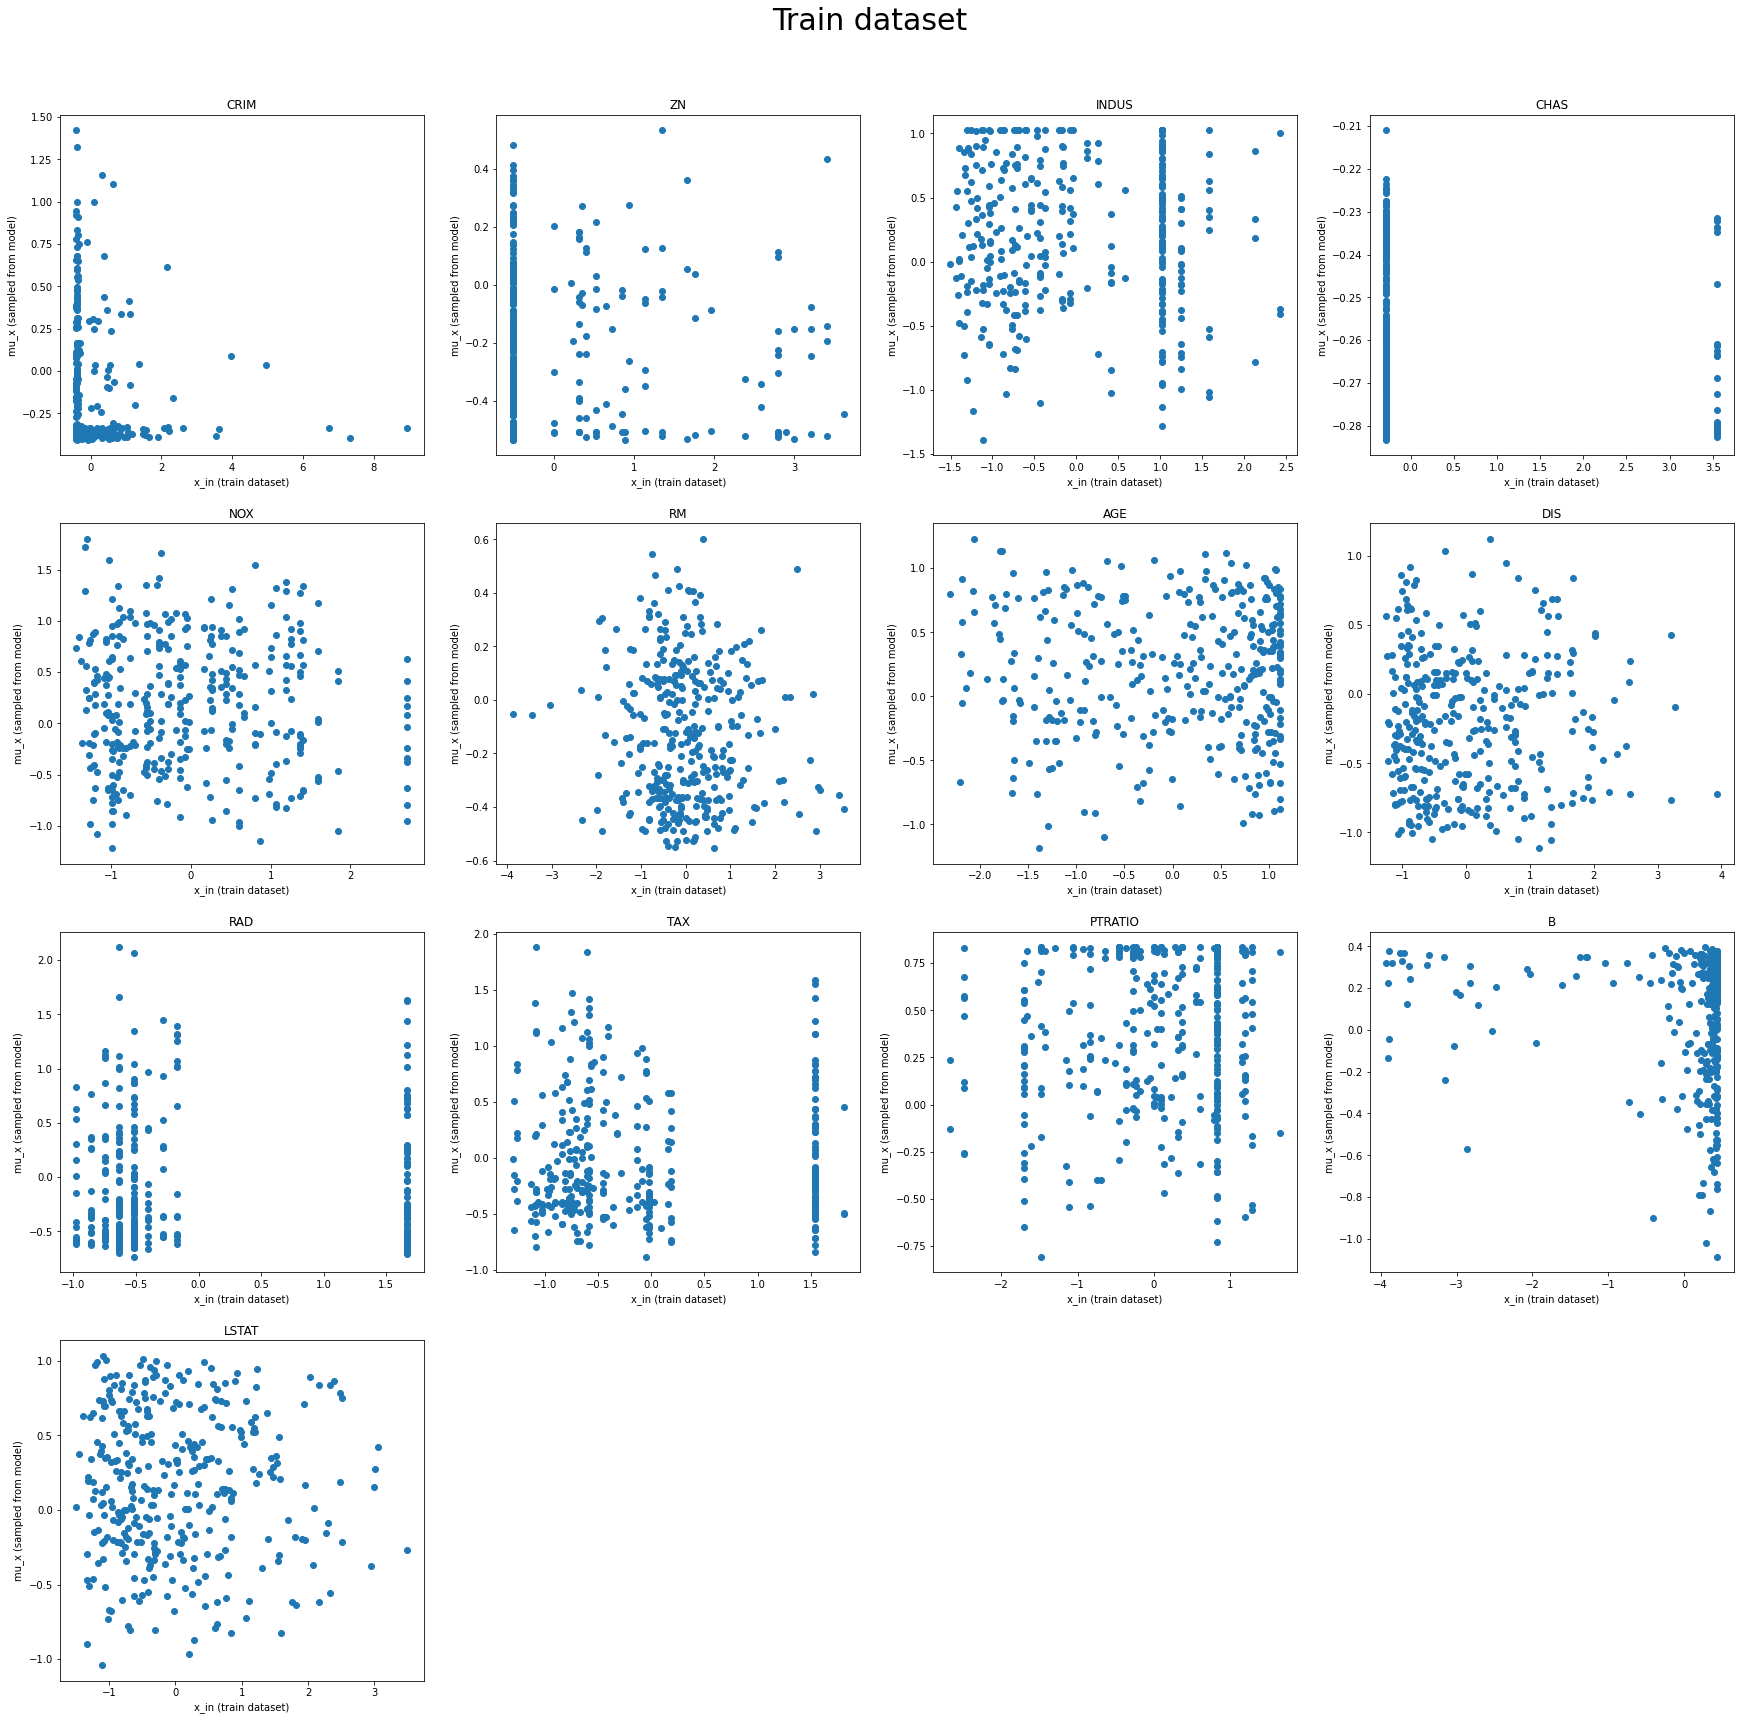

In [20]:
x_test = X_train.detach().numpy()
mu_x = mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 

for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(x_test[:,i*4+j], mu_x[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (sampled from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Train dataset", fontsize=30, y=0.9)
plt.subplots_adjust(top=0.85)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3])
        
plt.show()

In [21]:
np.corrcoef(X_test, rowvar=False)[0]

array([ 1.        , -0.21768376,  0.46992412, -0.02528763,  0.50245086,
       -0.38712153,  0.39103842, -0.43657444,  0.73175226,  0.67035584,
        0.31758966, -0.48275698,  0.62539329])

In [22]:
x_samples = x_samples.detach().numpy()

In [24]:
type(x_samples)

numpy.ndarray

In [25]:
np.corrcoef(x_samples, rowvar=False)[0]

array([ 1.        , -0.05574154,  0.01333075,  0.07808032, -0.04541089,
        0.13746088, -0.00665791,  0.10868618, -0.02081018,  0.03558787,
       -0.08148184,  0.08909845,  0.05101724])

In [26]:
np.corrcoef(X_test, rowvar=False)[1]

array([-0.21768376,  1.        , -0.49523118,  0.03714962, -0.49851041,
        0.34197449, -0.51751587,  0.62983191, -0.30477226, -0.28687676,
       -0.43829561,  0.15646899, -0.38841192])

In [27]:
np.corrcoef(x_samples, rowvar=False)[1]

array([-0.05574154,  1.        , -0.43616519, -0.13868853, -0.04537399,
        0.09894059, -0.20220733,  0.09864264, -0.25122805, -0.39969607,
       -0.02682422,  0.12135908, -0.17410124])